# Bank Classification Project - EDA

I will structure my project around [Jeff Leek's data analysis checklist](https://leanpub.com/datastyle).

## The Problem Domain

**Briar's Community Bank** - We are having a campaign. We want people to subscribe to a term deposit. We have been recording our success rate on clients for a while. Can you tell us who we can convert based on their financial data?

We have their age, job, employees, their loans, if they have any credit defaults, when we called them, their education, etc., and we also recorded if our call was successful or not. What can we learn? What would be useful for us?

## Answering the Question

*Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?*

We are trying to classify clients who will subscribe to a term deposit based on several demographic and financial metrics.

*Did you define the metric for success before beginning?*
  
Since we are performing classification, we can use accuracy - the fraction of correctly classified clients - to quantify how well our model is performing. Our head of data has told us that we should achieve at least 90% accuracy.
  
*Did you understand the context for the question and the scientific or business application?*

We are building part of a data analysis pipeline that will be able to classify the client's propensity for term deposits from his/her data on file with the bank. In the future, this pipeline will be connection to another pipeline that automatically generates customized marketing material for clients to be used in digital and print channels.

*Did you record the experimental design?*

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

*Did you consider whether the question could be answered with the available data?*

The data set we currently have is specifically tailored to term deposits. There is additional information about other financial products like a housing loan or personal load, but it would hard to generalize the model to all the other personal financial products offered through a community bank.

In [1]:
# Imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.2)

import pandas_profiling
import pivottablejs
import missingno as msno

## Checking the Data

In [2]:
bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', 
                        sep=';', na_values=['NA'])

In [3]:
bank_data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [4]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

### Attribute Information for Reference

#### Bank client data

1. age (numeric)

2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5. default: has credit in default? (categorical: 'no','yes','unknown')

6. housing: has housing loan? (categorical: 'no','yes','unknown')

7. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign

8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). 

*Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

#### Other attributes

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [5]:
older = bank_data[bank_data.age > 60]

In [6]:
older.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 8645 to 41187
Data columns (total 21 columns):
age               910 non-null int64
job               910 non-null object
marital           910 non-null object
education         910 non-null object
default           910 non-null object
housing           910 non-null object
loan              910 non-null object
contact           910 non-null object
month             910 non-null object
day_of_week       910 non-null object
duration          910 non-null int64
campaign          910 non-null int64
pdays             910 non-null int64
previous          910 non-null int64
poutcome          910 non-null object
emp.var.rate      910 non-null float64
cons.price.idx    910 non-null float64
cons.conf.idx     910 non-null float64
euribor3m         910 non-null float64
nr.employed       910 non-null float64
y                 910 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 156.4+ KB


There are several interesting categorical and numerical features. I will need to do more industry research to decide which to filter and which to perform one-hot encoding on. This may lead to a high-dimensional sparse data set. 

## Tidying the Data

- Each variable is associated with one column
- Each observation is associated with one row

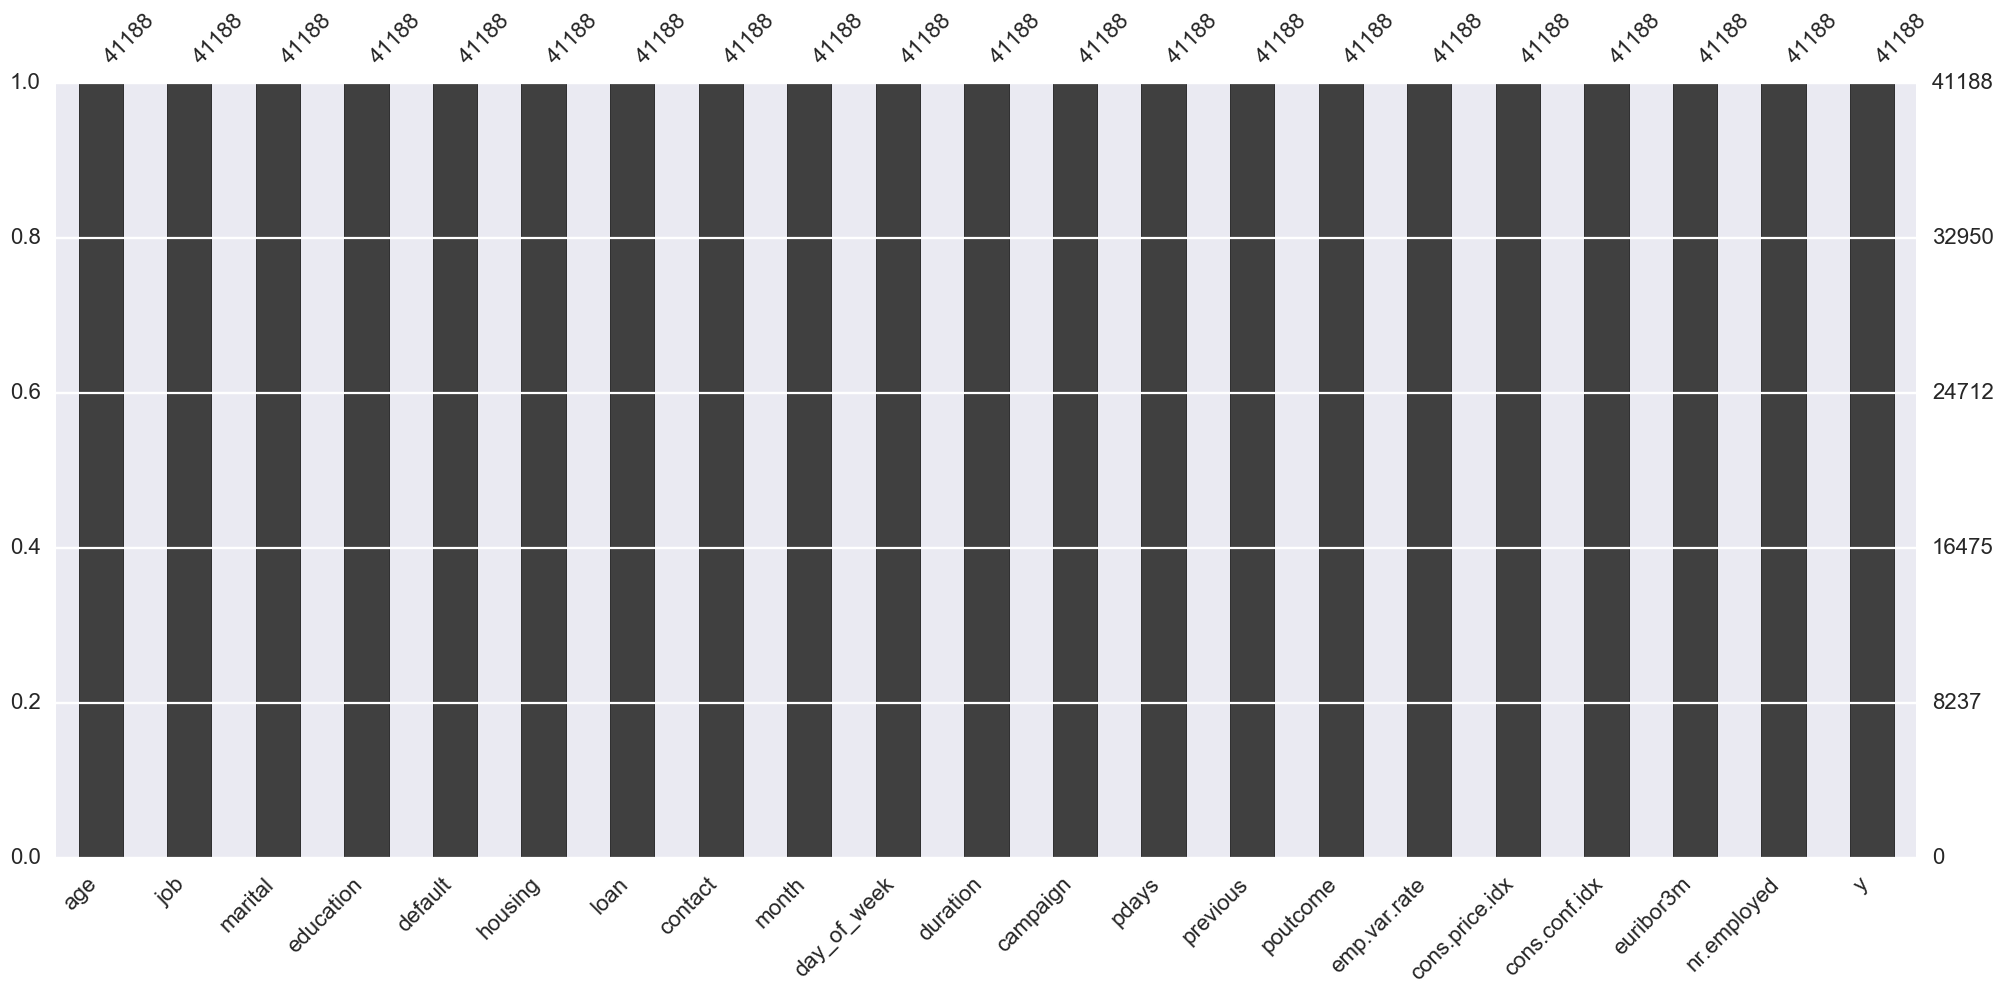

In [7]:
msno.bar(bank_data, labels=True)

No missing values??

In [8]:
bank_data.job.nunique()

12

In [9]:
bank_data.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

Listed as *unknown* for missing data. Let's have 2 pipelines, one with imputation and one where uknowns are dropped.

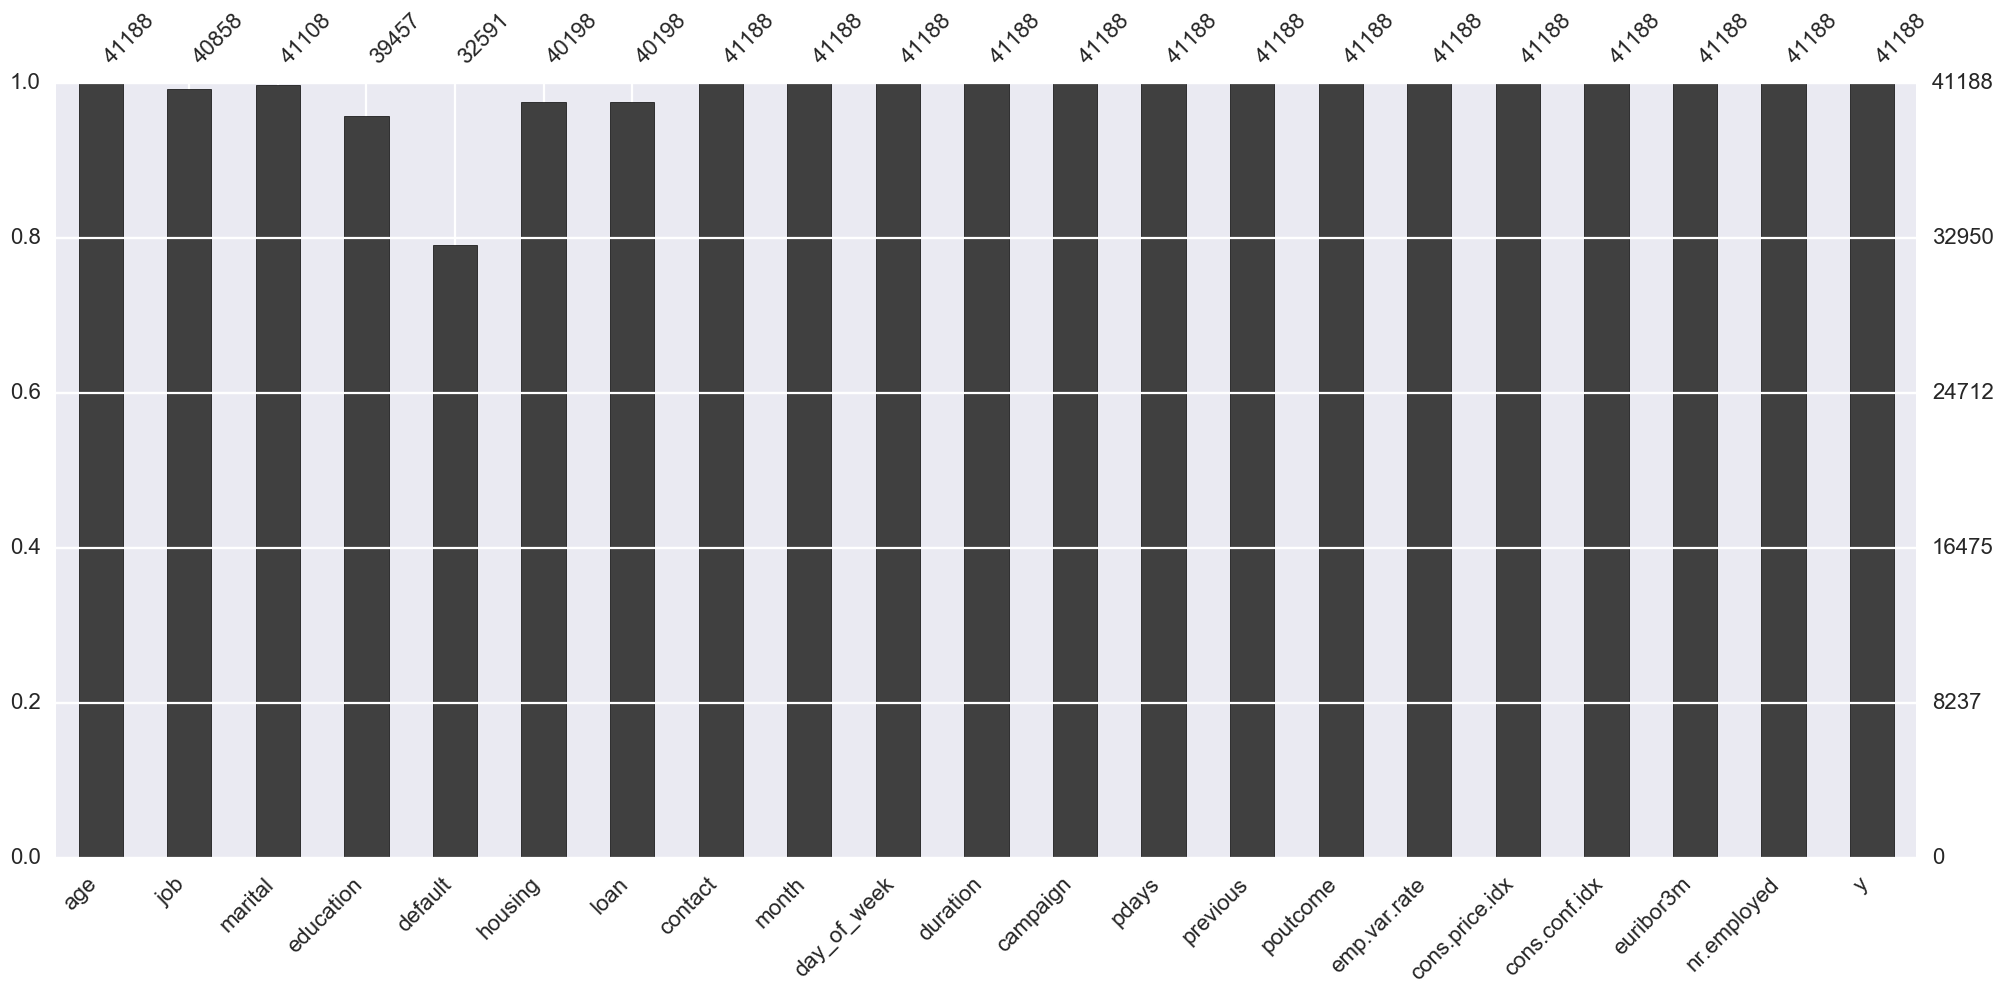

In [10]:
null_pattern = pd.DataFrame(bank_data).replace({"unknown": None})
msno.bar(null_pattern, labels=True)

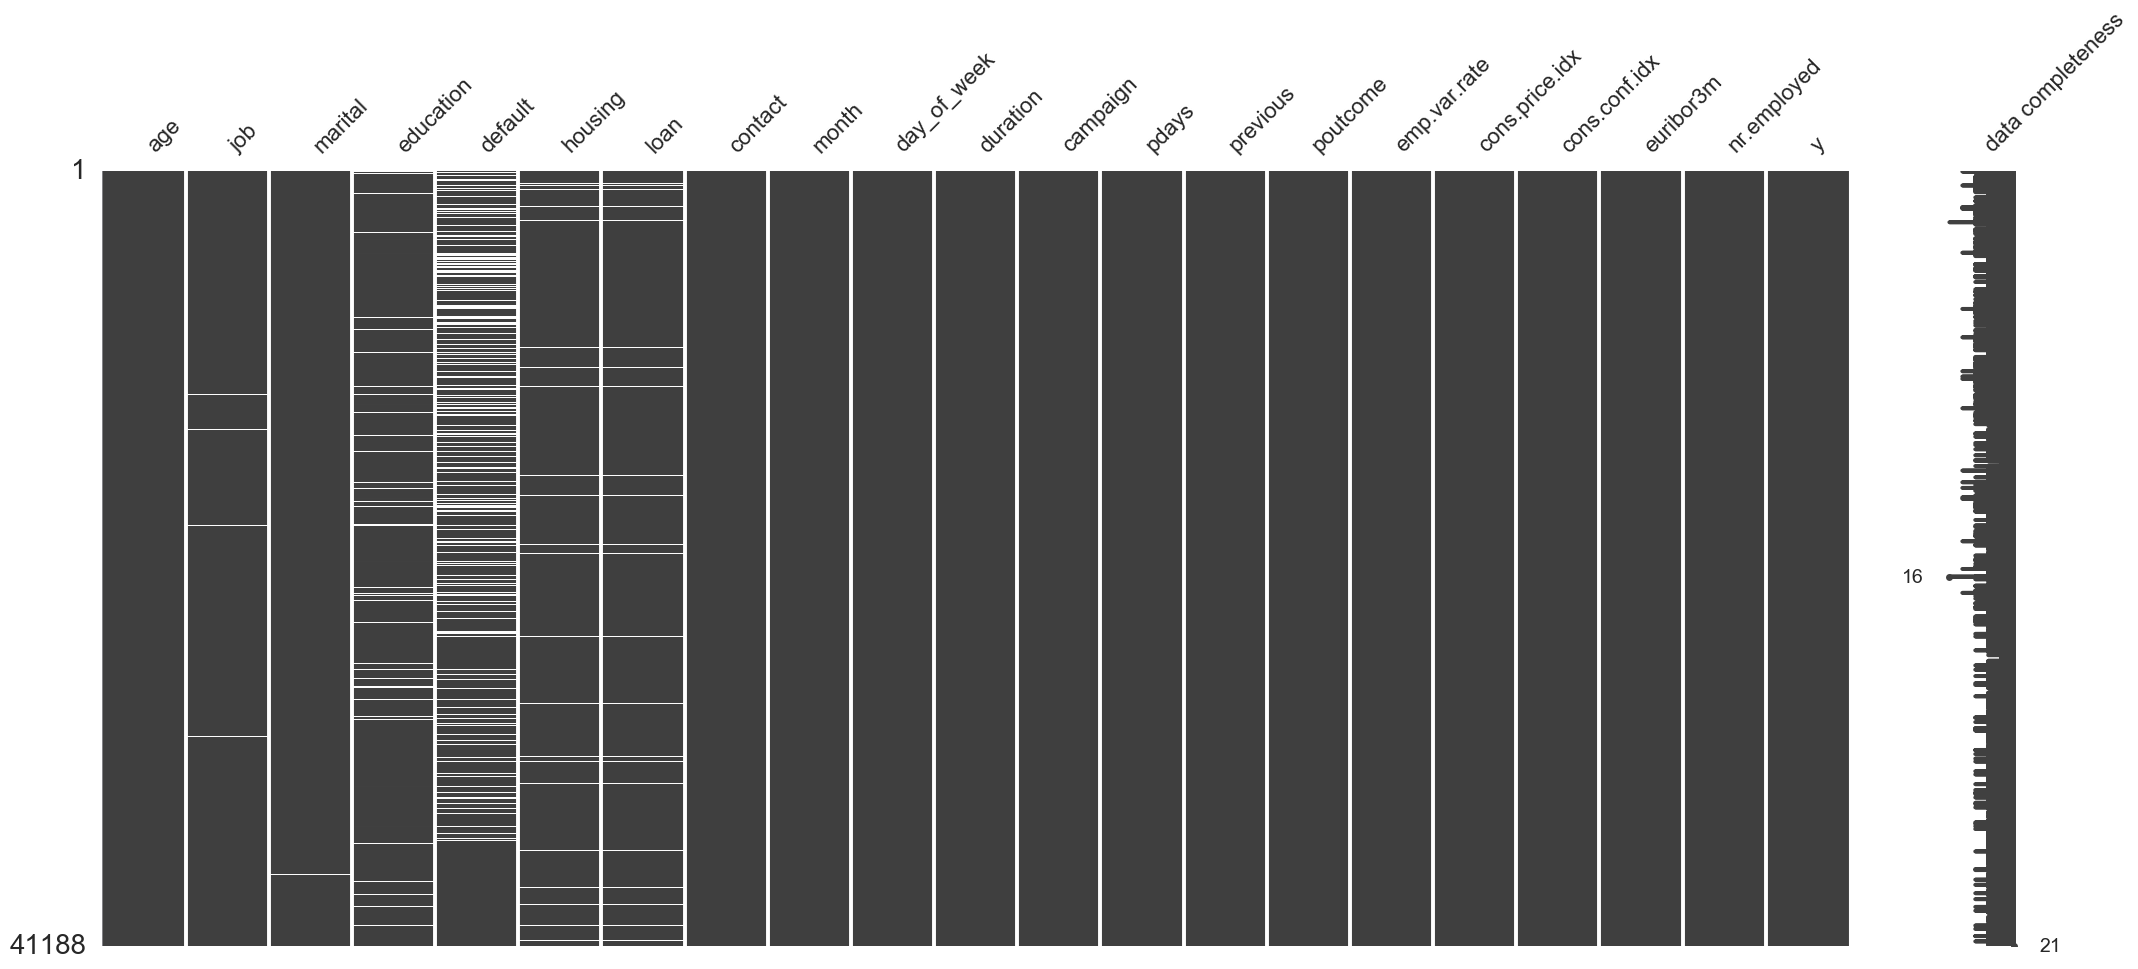

In [11]:
msno.matrix(null_pattern, labels=True)

Is there a pattern with defaults and not reporting?

In [12]:
bank_data.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [13]:
bank_data.groupby(['job', 'default']).mean()

age    duration  campaign       pdays  previous  \
job           default                                                          
admin.        no       37.622522  257.357432  2.589988  949.404535  0.207471   
              unknown  42.174787  232.811292  2.860015  989.018561  0.058778   
blue-collar   no       38.230618  267.368922  2.499014  980.246551  0.144054   
              unknown  42.103917  259.107075  2.672773  994.609286  0.081175   
entrepreneur  no       41.086580  258.269264  2.467532  978.370563  0.155844   
              unknown  44.166113  282.448505  2.797342  992.382060  0.073090   
housemaid     no       44.963563  252.422402  2.466937  948.063428  0.174089   
              unknown  46.746082  245.884013  3.040752  989.652038  0.053292   
management    no       41.647607  256.585969  2.409570  955.895377  0.208435   
              unknown  46.213974  259.600437  2.834061  999.000000  0.058952   
retired       no       63.388093  276.920874  2.405426  878.488320  0.385833   
              unknown  57.432570  262.877863  2.717557  963.603053  0.129771   
self-employed no       38.755926  264.523266  2.633011  971.956102  0.160667   
              unknown  44.769504  262.602837  2.773050  995.464539  0.074468   
services      no       36.859155  262.613167  2.567638  976.214543  0.176220   
              unknown  41.483624  244.349345  2.655022  992.504367  0.084061   
student       no       25.466926  287.671855  2.073930  822.661479  0.566796   
              unknown  29.067308  254.115385  2.326923  970.365385  0.211538   
technician    no       37.731483  249.707892  2.546921  959.228794  0.173461   
              unknown  43.072746  253.638320  2.760246  994.930328  0.037910   
              yes      48.000000   99.500000  1.000000  999.000000  0.000000   
unemployed    no       38.668814  250.076031  2.456186  918.347938  0.230670   
              unknown  43.257384  247.991561  2.919831  990.607595  0.092827   
              yes      31.000000  111.000000  2.000000  999.000000  1.000000   
unknown       no       44.275281  261.573034  2.528090  898.415730  0.241573   
              unknown  47.072368  214.032895  2.789474  985.934211  0.052632   

                       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
job           default                                                           
admin.        no          -0.094786       93.508720     -40.304995   3.432541   
              unknown      0.794664       93.712916     -39.824903   4.381502   
blue-collar   no           0.065342       93.591979     -41.641179   3.575524   
              unknown      0.602148       93.781025     -40.865540   4.149797   
entrepreneur  no           0.032294       93.561094     -41.377489   3.663978   
              unknown      0.643854       93.775276     -40.923588   4.278987   
housemaid     no           0.205533       93.618479     -39.399190   3.776054   
              unknown      0.962696       93.811530     -39.718495   4.552251   
management    no          -0.136780       93.476105     -40.498459   3.491648   
              unknown      0.655459       93.773937     -40.441048   4.255642   
retired       no          -1.109194       93.328485     -38.342728   2.331491   
              unknown      0.689059       93.776214     -39.350891   4.250954   
self-employed no          -0.070325       93.504116     -40.580070   3.515724   
              unknown      0.758511       93.785624     -40.116667   4.390759   
services      no           0.041631       93.599023     -41.515919   3.549242   
              unknown      0.621070       93.753432     -40.537227   4.198948   
student       no          -1.585473       93.299316     -40.117899   1.677497   
              unknown     -0.092308       93.571038     -40.703846   3.416788   
technician    no           0.159428       93.530141     -40.053686   3.694870   
              unknown      0.952357       93.746773     -39.190471   4.559539   
      

Interestingly, older individuls in almost every category except for retired, seemed to either not report or were not asked about their previous default status.

In [14]:
pivottablejs.pivot_ui(bank_data,)

In [15]:
pandas_profiling.ProfileReport(bank_data)

## Exploratory Analysis

### Bank Client Data

In [16]:
bank_client = bank_data.iloc[:, :7]

In [17]:
bank_client.head()

age        job  marital    education  default housing loan
0   56  housemaid  married     basic.4y       no      no   no
1   57   services  married  high.school  unknown      no   no
2   37   services  married  high.school       no     yes   no
3   40     admin.  married     basic.6y       no      no   no
4   56   services  married  high.school       no      no  yes

In [18]:
bank_client.age.describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

In [19]:
bank_client.age.median()

38.0

In [20]:
bank_client.age.skew()

0.78469681576466455

Small positive skew, tiny right skew and higher concentration of lower ages.

In [21]:
bank_client.age.kurtosis()

0.79131153115443364

Small positive kurtosis, not many outliers.

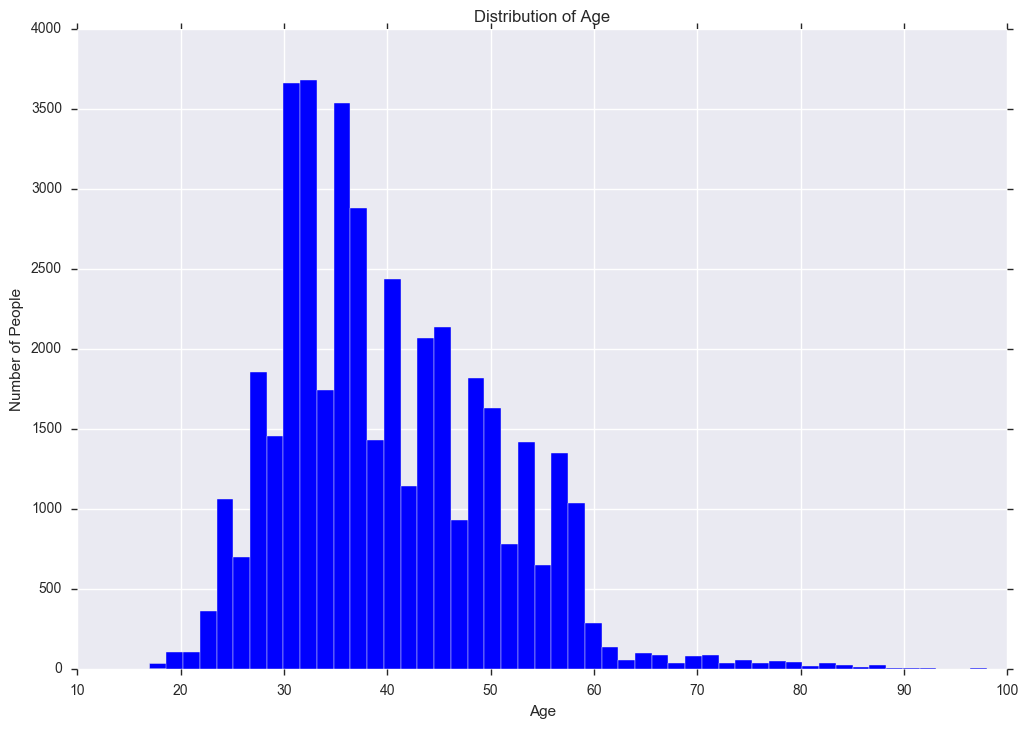

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(bank_client.age.values, bins=50);
ax.set_xlabel('Age');
ax.set_ylabel('Number of People');
ax.set_title('Distribution of Age');

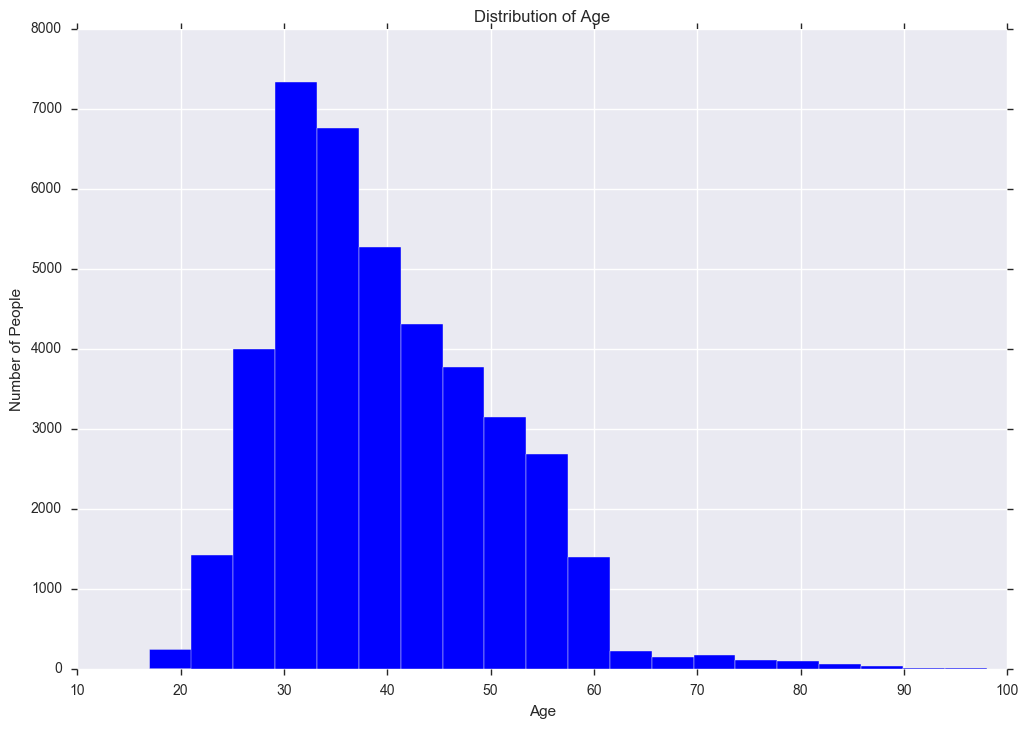

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(bank_client.age.values, bins=20);
ax.set_xlabel('Age');
ax.set_ylabel('Number of People');
ax.set_title('Distribution of Age');

In [24]:
def plot_hist(df, variable, bins=20, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):

    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
    if logx:
        if df[variable].min() <=0:
            df[variable] = df[variable] - df[variable].min() + 1
            print('Warning: data <=0 exists, data transformed by %0.2g before plotting' % (- df[variable].min() + 1))
        
        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        ax.set_xscale("log")

    ax.hist(df[variable].dropna().values, bins=bins);
    
    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);
    
    return ax

### Additional Client Data

In [25]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [26]:
add_client = bank_data.iloc[:, 10:14]
add_client.head()

duration  campaign  pdays  previous
0       261         1    999         0
1       149         1    999         0
2       226         1    999         0
3       151         1    999         0
4       307         1    999         0

In [27]:
add_client.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

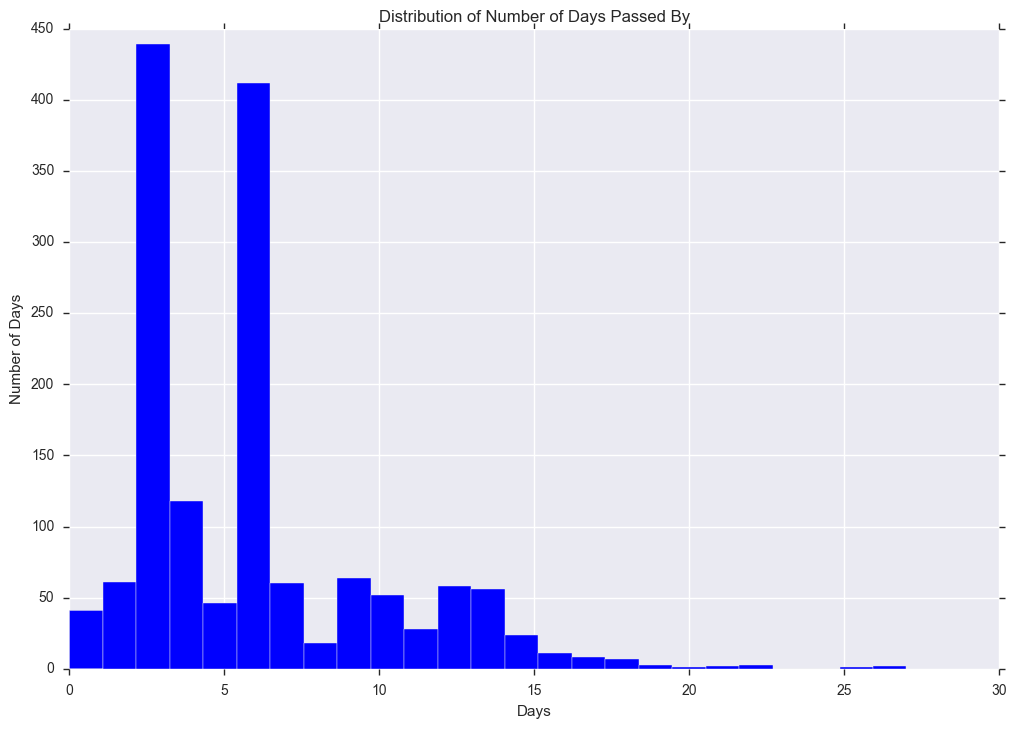

In [28]:
less_outliers = add_client[add_client["pdays"] < 900]

plot_hist(less_outliers, 'pdays', bins=25,
        xlabel='Days', ylabel='Number of Days',
        title='Distribution of Number of Days Passed By');

### Social & Economic Indicators

In [29]:
econ = bank_data.iloc[:, -6:-1]
econ.head()

emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
0           1.1          93.994          -36.4      4.857       5191.0
1           1.1          93.994          -36.4      4.857       5191.0
2           1.1          93.994          -36.4      4.857       5191.0
3           1.1          93.994          -36.4      4.857       5191.0
4           1.1          93.994          -36.4      4.857       5191.0

### Multivariate EDA

In [30]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [31]:
# Quick look at the target variable
print("Target variable 'y' is yes or no -> classification problem")
print("Number of yes : " + str(bank_data[bank_data.y == "yes"].shape[0]))
print("Number of no : " + str(bank_data[bank_data.y == "no"].shape[0]))

Target variable 'y' is yes or no -> classification problem
Number of yes : 4640
Number of no : 36548


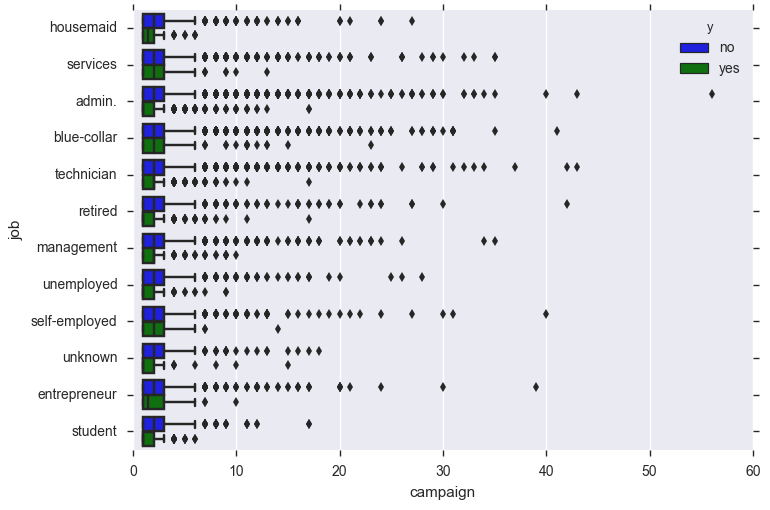

In [32]:
sns.boxplot(x="campaign", y="job", hue="y", data=bank_data);

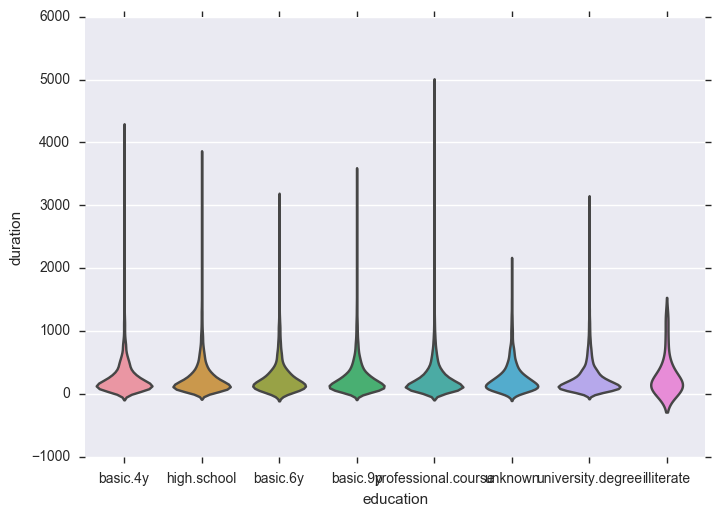

In [33]:
sns.violinplot(x="education", y="duration", data=bank_data, inner=None);

In [34]:
corr = bank_data.corr()

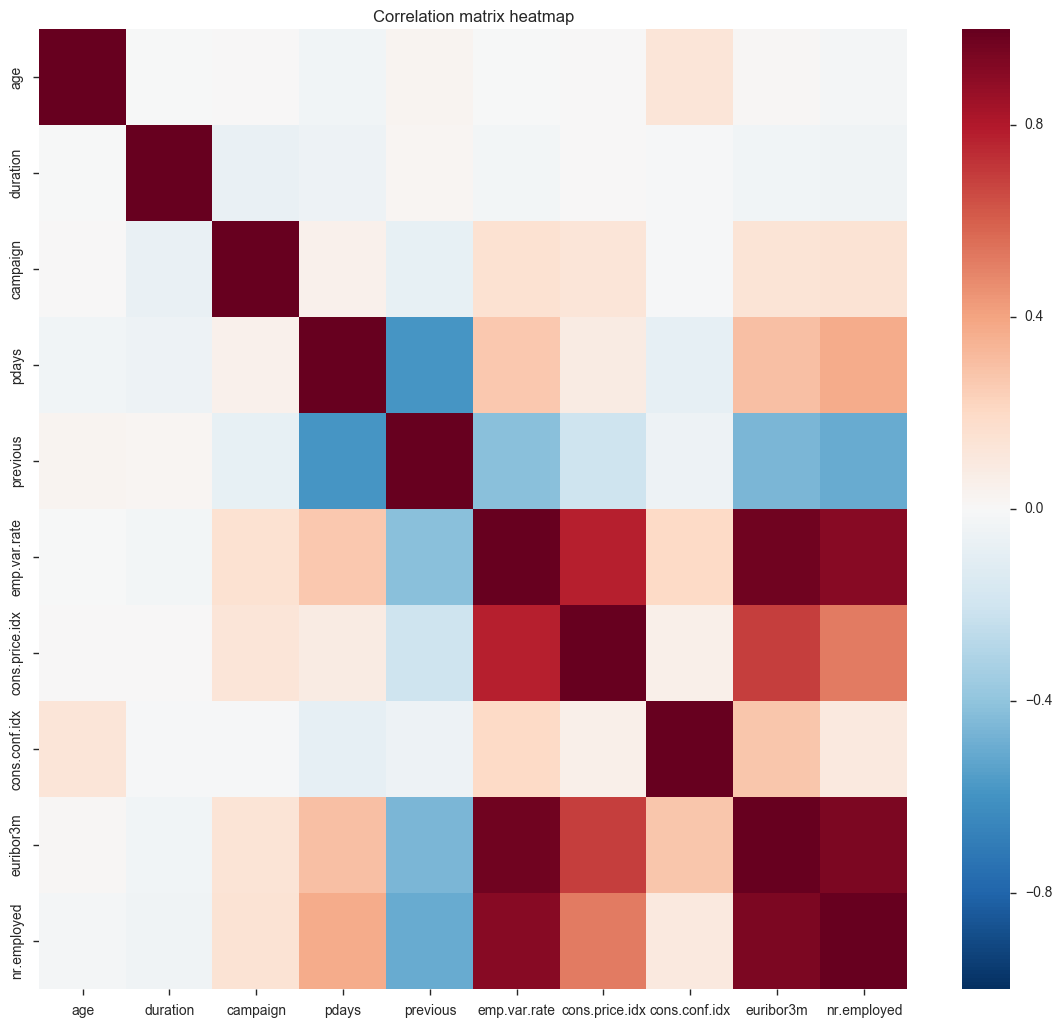

In [35]:
fig, ax = plt.subplots(figsize=(14,12));
sns.heatmap(corr, ax=ax);
plt.xlabel('');
plt.ylabel('');
plt.title('Correlation matrix heatmap');

In [36]:
def plot_jointplot(df, var1, var2, kind="hex", gridsize=15):
    g = sns.jointplot(var1, var2, df, kind=kind, gridsize=gridsize)
    return g

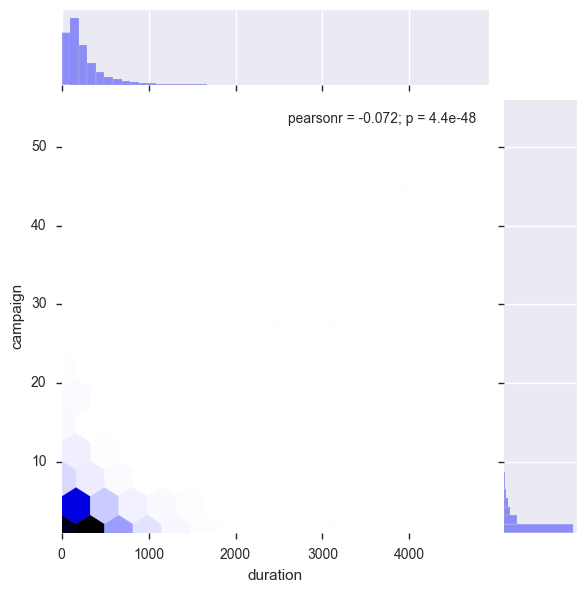

In [37]:
var1 = 'duration'
var2 = 'campaign'
plot_jointplot(bank_data, var1, var2);

In [38]:
def plot_pairplot(df, variables, hue):
    sns.set(style="ticks", color_codes=True);
    pair_plot = sns.pairplot(df[variables].dropna(), hue=hue);
    return pair_plot

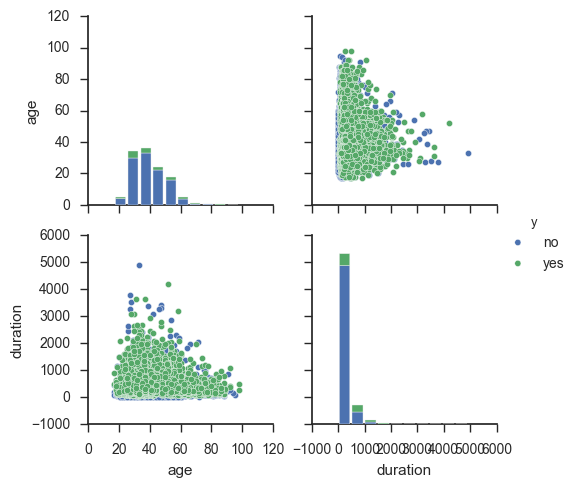

In [39]:
variables_to_plot = ['age', 'duration', 'y']
plot_pairplot(bank_data, variables_to_plot, "y");

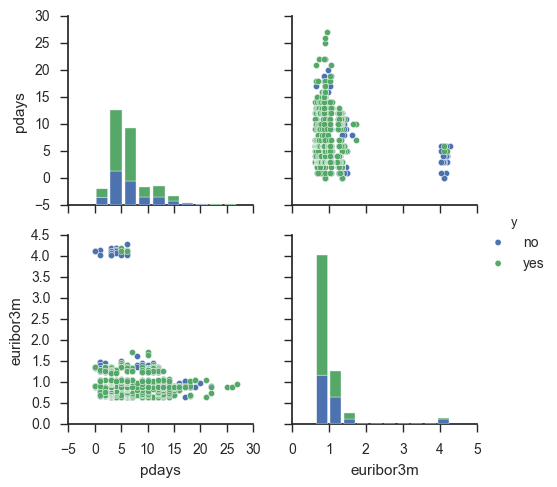

In [40]:
temp_df = bank_data[bank_data["pdays"] < 900]
variables_to_plot = ['pdays', 'euribor3m', 'y']
plot_pairplot(temp_df, variables_to_plot, "y");